In [92]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from keras import Sequential
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,StackingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ( confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score,auc)
from sklearn.linear_model import LogisticRegression
from typing import List, Dict,Tuple
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from xgboost import XGBClassifier
from sklearn.decomposition import PCA


In [93]:
data:pd.DataFrame = pd.read_csv("telescope_data.csv")

In [94]:
def clean_column_names (col_name:str) -> str:
    return re.sub(r'^f', '', col_name)


def toInt (col:str) -> int:
    return 1 if col == 'g' else 0

In [95]:
data.rename(columns={col: clean_column_names(col) for col in data.columns}, inplace=True)

data.rename(columns={"class": "Class"}, inplace=True)

data.drop("Unnamed: 0", axis=1, inplace=True)

data.Class = data.Class.apply(toInt)


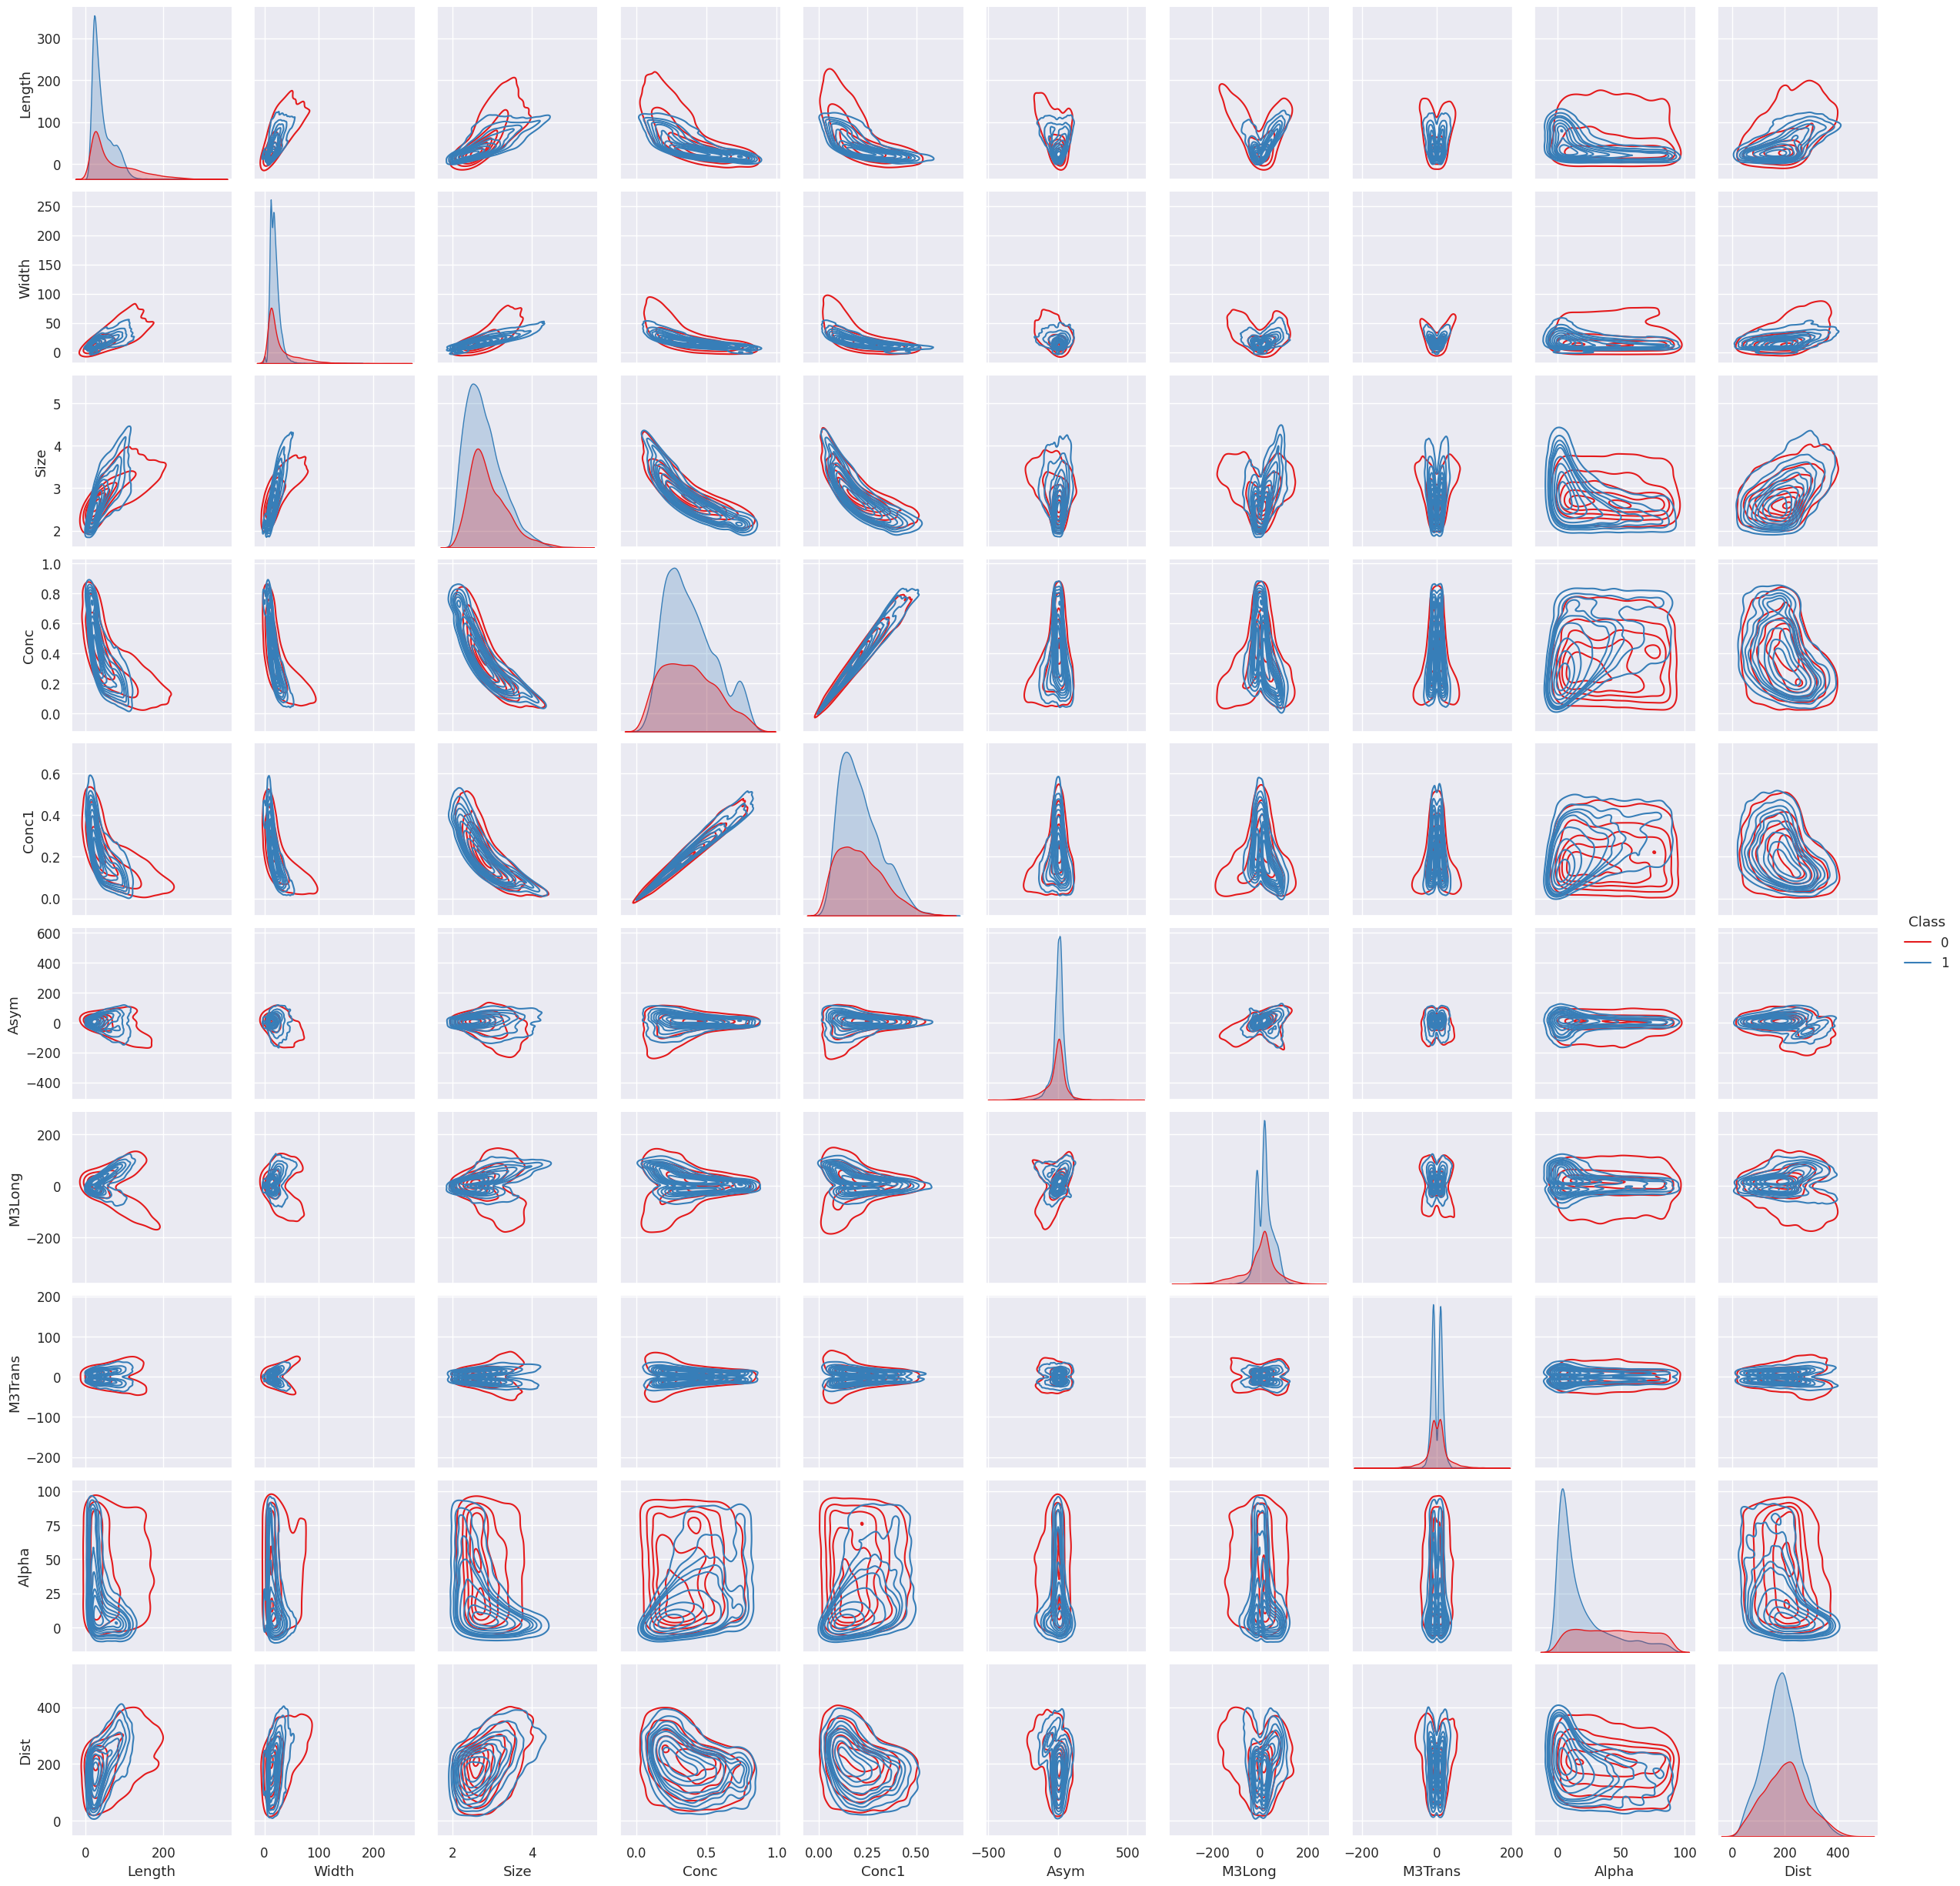

In [96]:
sns.pairplot(data, hue="Class", kind="kde", palette="Set1")
plt.show()

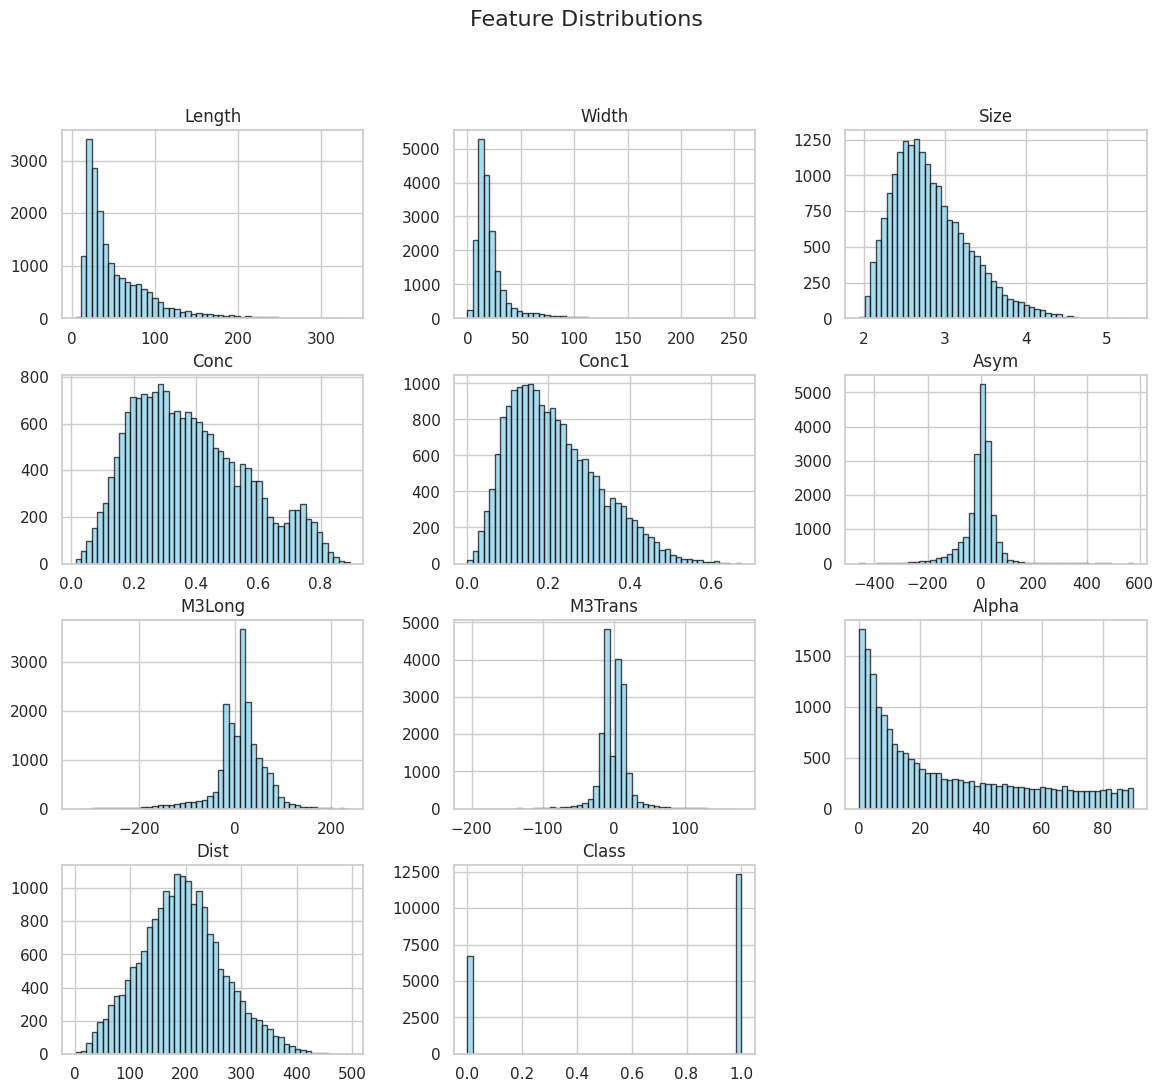

In [97]:
sns.set(style="whitegrid")
data.hist(figsize=(14, 12), bins=50, edgecolor="black", color="skyblue", alpha=0.7)
plt.suptitle("Feature Distributions", fontsize=16)
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap')

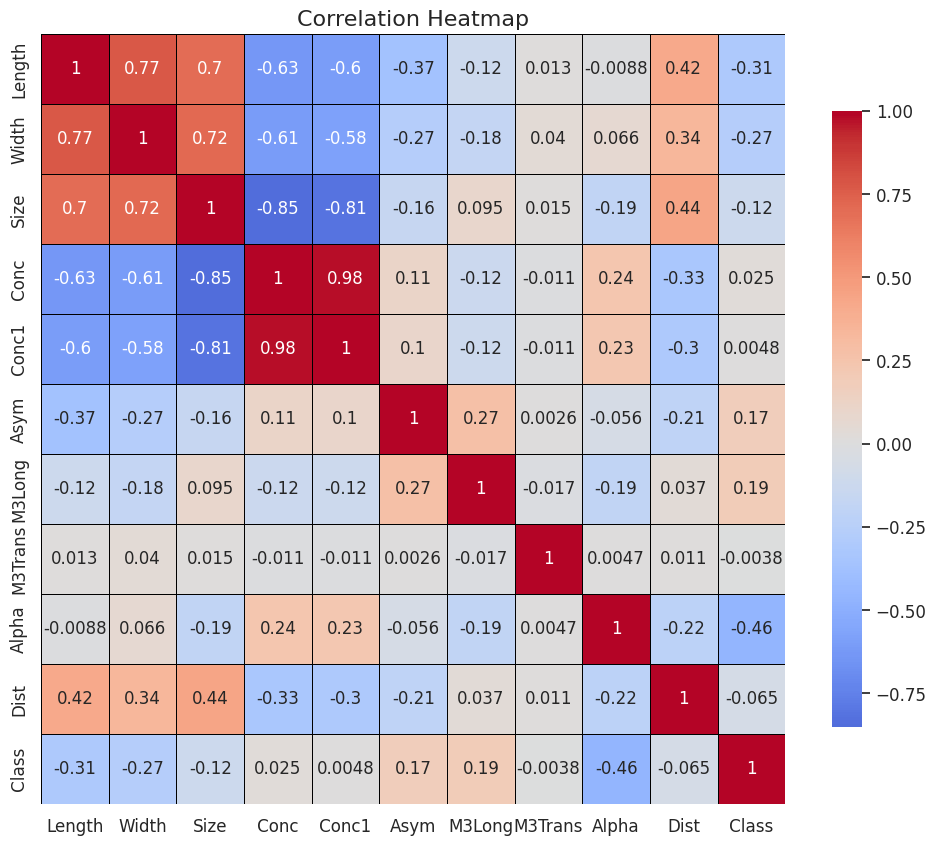

In [98]:
plt.figure(figsize=(12, 10))
sns.set(font_scale=1.1)
correlation_matrix:pd.DataFrame = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm",
            center=0, linewidths=0.5, linecolor="black",
            cbar_kws={"shrink": 0.8}, annot_kws={"size": 12})
plt.title("Correlation Heatmap", fontsize=16)

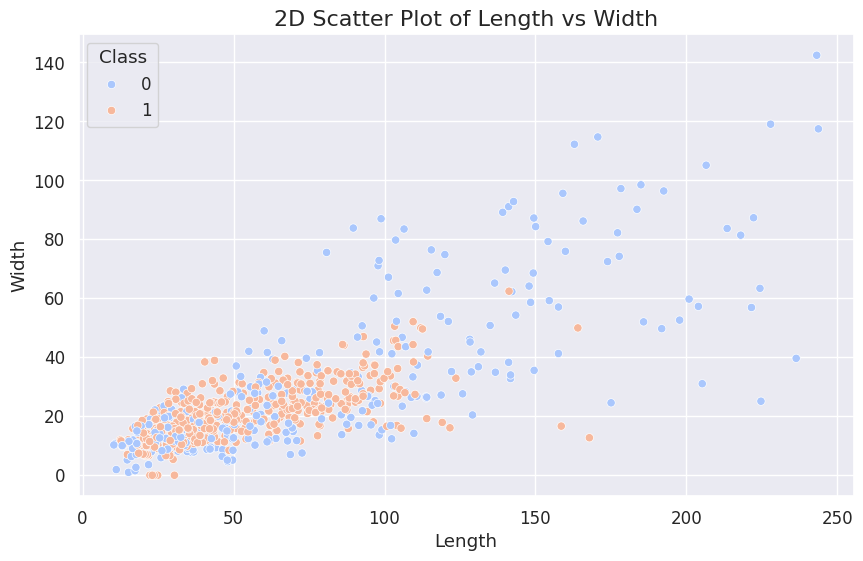

In [99]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="Length", y="Width", hue="Class", data=data.sample(1000), palette="coolwarm")
plt.title("2D Scatter Plot of Length vs Width", fontsize=16)
plt.show()

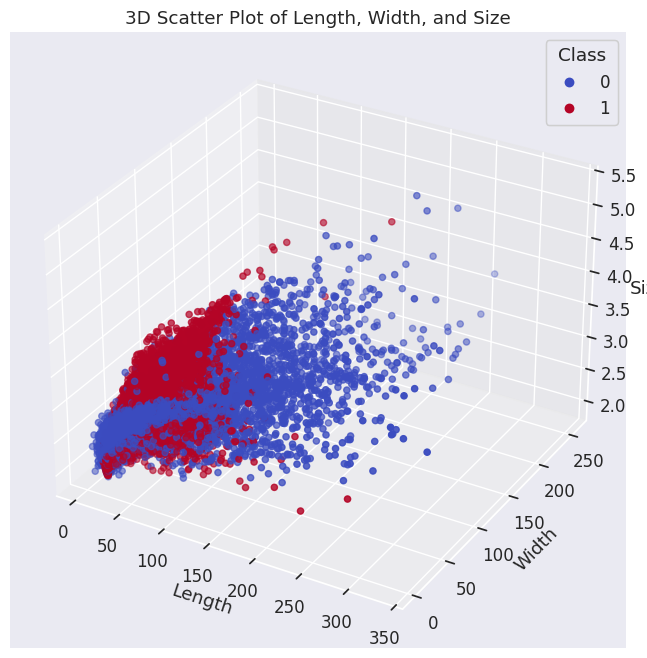

In [100]:
fig:plt.Figure = plt.figure(figsize=(10, 8))
ax:plt.Axes = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(data.Length, data.Width, data.Size, c=data.Class, cmap="coolwarm")
legend1 = ax.legend(*scatter.legend_elements(), title="Class")
ax.add_artist(legend1)
ax.set_xlabel("Length")
ax.set_ylabel("Width")
ax.set_zlabel("Size")
plt.title("3D Scatter Plot of Length, Width, and Size")
plt.show()

In [101]:
x:pd.DataFrame = data.drop("Class", axis=1)
y:pd.DataFrame = data.Class

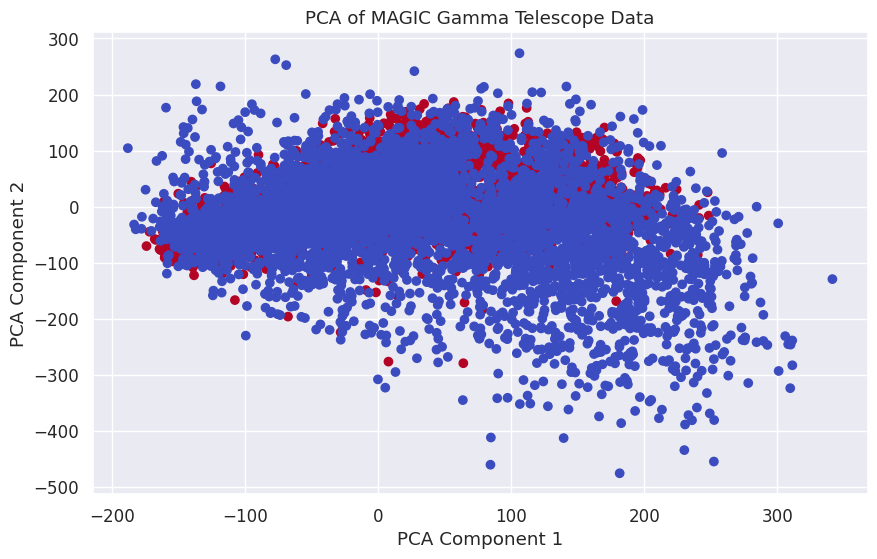

In [102]:
pca:PCA = PCA(n_components=2)
pca_result:np.ndarray = pca.fit_transform(x)
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, cmap='coolwarm')
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of MAGIC Gamma Telescope Data")
plt.show()

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [104]:
scaler:StandardScaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)


In [105]:
y_train.value_counts()

Class
1    8627
0    4687
Name: count, dtype: int64

In [106]:
def print_metrics (model_list: List) -> Dict:
    global y_test
    global x_test_scaled
    metrics_dict: Dict = {}
    
    for model in model_list:
        if "keras" in str(type(model)).lower():
            x_test_array = np.array(x_test_scaled)
            preds_proba:np.ndarray = model.predict(x_test_array)
            preds:np.ndarray = (preds_proba > 0.5).astype(int).flatten()
        else:
            preds:np.ndarray = model.predict(x_test_scaled)
            if preds.ndim > 1 and preds.shape[1] == 1:
                preds = (preds > 0.5).astype(int).flatten()
        
        accuracy:float = accuracy_score(y_test, preds)
        precision:float = precision_score(y_test, preds, average="macro")
        f1:float = f1_score(y_test, preds, average="macro")
        recall:float = recall_score(y_test, preds, average="macro")
        conf_matrix = confusion_matrix(y_test, preds)
        roc_auc:float = roc_auc_score(y_test, preds, multi_class="ovr") if len(set(y_test)) > 2 else roc_auc_score(y_test,
                                                                                                             preds)
        
        metrics_dict[model.__class__.__name__] = {
            "Accuracy Score": accuracy,
            "Precision Score": precision,
            "F1 Score": f1,
            "Recall Score": recall,
            "Confusion Matrix": conf_matrix.tolist(),
            "ROC AUC Score": roc_auc
        }
    
    return metrics_dict


In [107]:
param_grid:Dict = {
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "criterion": ["gini", "entropy"]
}

In [108]:
models: List = []

In [109]:
logistic_model:LogisticRegression= LogisticRegression(random_state=42, max_iter=5000)
logistic_model.fit(x_train_scaled, y_train)
models.append(logistic_model)

In [110]:
decision_tree:DecisionTreeClassifier = DecisionTreeClassifier(random_state=42)
grid_search:GridSearchCV = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=5, scoring="accuracy", n_jobs=-1,
                           verbose=True)
grid_search.fit(x_train_scaled, y_train)
best_tree = grid_search.best_estimator_
models.append(best_tree)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [111]:
random_forest:RandomForestClassifier = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
random_forest.fit(x_train_scaled, y_train)
models.append(random_forest)

In [112]:
gradient_boost:GradientBoostingClassifier = GradientBoostingClassifier(random_state=42)
gradient_boost.fit(x_train_scaled, y_train)
models.append(gradient_boost)

In [113]:
ada_boost:AdaBoostClassifier = AdaBoostClassifier(random_state=42, algorithm="SAMME")
ada_boost.fit(x_train_scaled, y_train)
models.append(ada_boost)

In [114]:
xg_boost:XGBClassifier = XGBClassifier(random_state=42)
xg_boost.fit(x_train_scaled, y_train)
models.append(xg_boost)

In [115]:
estimators:List[Tuple] = [
    ("rf", RandomForestClassifier(n_estimators=50, random_state=42,n_jobs=-1)),
    ("gb", GradientBoostingClassifier(random_state=42))
]

In [116]:
stacking_clf:StackingClassifier = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_clf.fit(x_train_scaled, y_train)
models.append(stacking_clf)

In [117]:
X_train_scaled:np.ndarray = np.array(x_train_scaled)
X_test_scaled:np.ndarray = np.array(x_test_scaled)
neural_net:Sequential = Sequential()
neural_net.add(Input(shape=(x_train.shape[1],)))
neural_net.add(Dense(128, activation="relu"))
neural_net.add(Dropout(0.5))
neural_net.add(Dense(64, activation="relu"))
neural_net.add(Dense(1, activation="sigmoid"))
neural_net.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
history = neural_net.fit(
    X_train_scaled,
    y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)
models.append(neural_net)

Epoch 1/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.7606 - loss: 0.5081 - val_accuracy: 0.8412 - val_loss: 0.3857
Epoch 2/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.8237 - loss: 0.3982 - val_accuracy: 0.8427 - val_loss: 0.3684
Epoch 3/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.8384 - loss: 0.3765 - val_accuracy: 0.8547 - val_loss: 0.3495
Epoch 4/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.8412 - loss: 0.3759 - val_accuracy: 0.8573 - val_loss: 0.3427
Epoch 5/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.8446 - loss: 0.3637 - val_accuracy: 0.8618 - val_loss: 0.3365
Epoch 6/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.8536 - loss: 0.3444 - val_accuracy: 0.8588 - val_loss: 0.3316
Epoch 7/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.8586 - loss: 0.3325 - val_accuracy: 0.8641 - val_loss: 0.3271
Epoch 8/20
333/333 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.8586 - loss: 0.3383 - 

In [118]:
metrics:Dict = print_metrics(models)
simple_metrics:Dict = {model: {k: v for k, v in metrics[model].items() if isinstance(v, (int, float,list))} for model in metrics}
metrics_data:pd.DataFrame = pd.DataFrame.from_dict(simple_metrics, orient="index")
metrics_data["Model Name"] = metrics_data.index
metrics_data.reset_index(inplace=True, drop=True)
metrics_data = metrics_data[["Model Name"] + [col for col in metrics_data.columns if col != "Model Name"]]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step


In [119]:
metrics_data

,Model Name,Accuracy Score,Precision Score,F1 Score,Recall Score,Confusion Matrix,ROC AUC Score
0,LogisticRegression,0.793551,0.785502,0.758643,0.746560,"[[1179, 822], [356, 3349]]",0.746560
1,DecisionTreeClassifier,0.848756,0.844496,0.827548,0.816881,"[[1421, 580], [283, 3422]]",0.816881
2,RandomForestClassifier,0.878023,0.874625,0.862449,0.853668,"[[1545, 456], [240, 3465]]",0.853668
3,GradientBoostingClassifier,0.872064,0.875875,0.853019,0.839426,"[[1461, 540], [190, 3515]]",0.839426
4,AdaBoostClassifier,0.827725,0.818178,0.804331,0.795400,"[[1375, 626], [357, 3348]]",0.795400
5,XGBClassifier,0.881703,0.879403,0.866439,0.857192,"[[1551, 450], [225, 3480]]",0.857192
6,StackingClassifier,0.878724,0.875015,0.863385,0.854898,"[[1551, 450], [242, 3463]]",0.854898
7,Sequential,0.871714,0.875879,0.852488,0.838697,"[[1457, 544], [188, 3517]]",0.838697


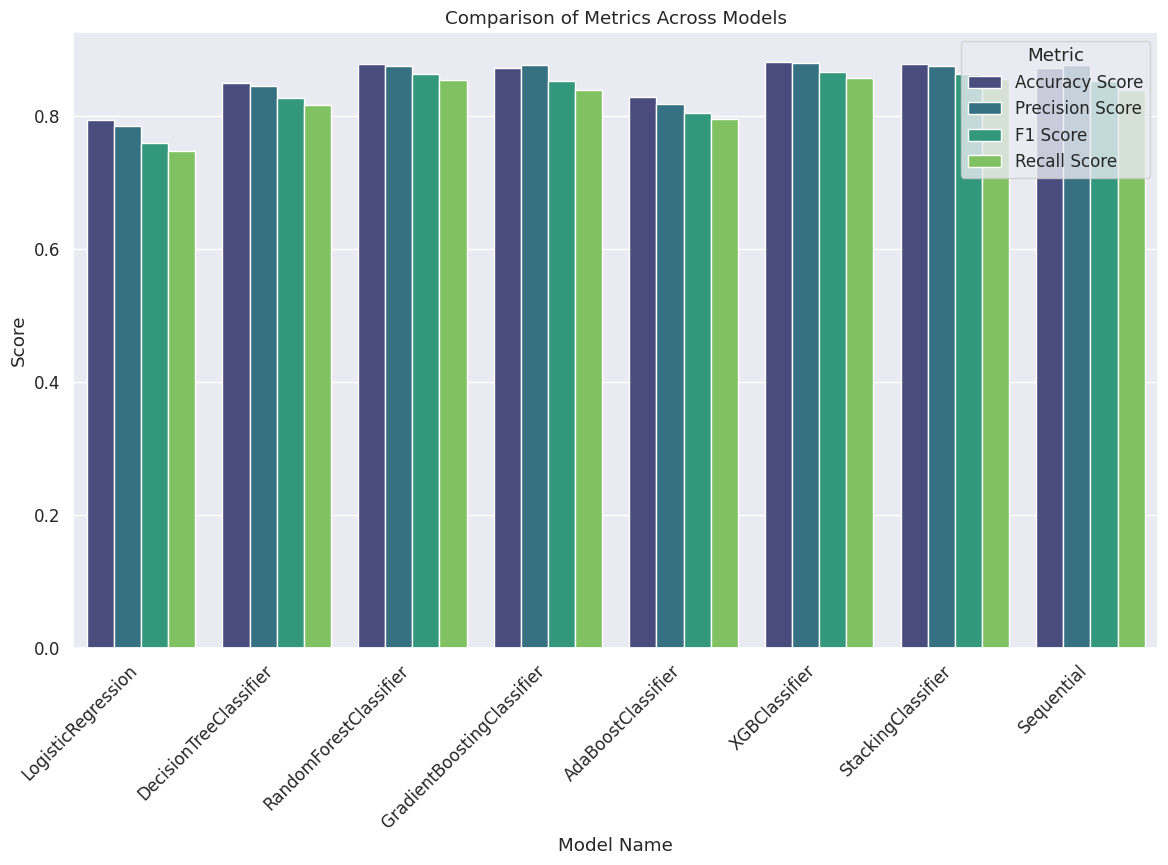

In [120]:
metrics_long:pd.DataFrame = metrics_data.melt(id_vars="Model Name", 
                                  value_vars=["Accuracy Score", "Precision Score", "F1 Score", "Recall Score"],
                                  var_name="Metric", 
                                  value_name="Score")

plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_long, x="Model Name", y="Score", hue="Metric", palette="viridis")
plt.title("Comparison of Metrics Across Models")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Score")
plt.show()

In [121]:
thresholds:List[float] = [0.01, 0.02, 0.05, 0.1, 0.2]

179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step


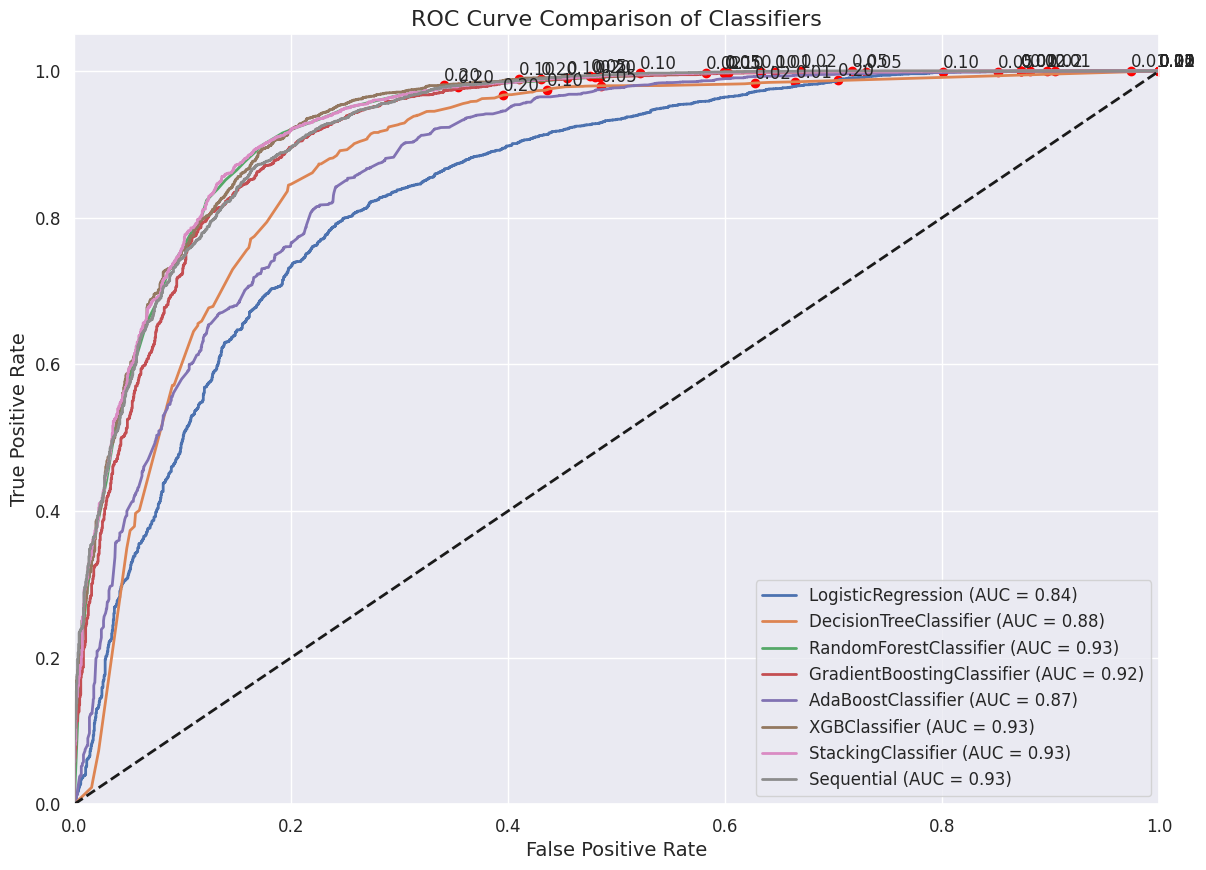

In [122]:
def plot_roc_curves():
    global thresholds
    global models
    plt.figure(figsize=(14, 10))
    x_test_array:np.ndarray = np.array(x_test_scaled)
    
    for model in models:
        if "keras" in str(type(model)).lower():
            preds_proba = model.predict(x_test_array).ravel()
        else:
            preds_proba = model.predict_proba(x_test_scaled)[:, 1]
        
        fpr, tpr, threshold_values = roc_curve(y_test, preds_proba)
        roc_auc:float = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, lw=2, label=f"{model.__class__.__name__} (AUC = {roc_auc:.2f})")
        
        for threshold in thresholds:
            close_point_idx = np.argmin(np.abs(threshold_values - threshold))
            plt.scatter(fpr[close_point_idx], tpr[close_point_idx], marker='o', color="red")
            plt.text(fpr[close_point_idx], tpr[close_point_idx], f"{threshold:.2f}", fontsize=12, verticalalignment='bottom')
    
    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate", fontsize=14)
    plt.ylabel("True Positive Rate", fontsize=14)
    plt.title("ROC Curve Comparison of Classifiers", fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.show()

plot_roc_curves()